# 0. Setup

Importing required packages and storing functions


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import re
from datetime import timedelta

# 1. Data Preparation

Loading raw data and preparing them in a format that can be used for analysis

## 1.1 COVID vaccination Data

In [2]:
covid_vaccination = pd.read_csv('raw_data/COVID-19_Vaccinations_in_the_United_States_County.csv')
covid_vaccination.head()

,Date,FIPS,MMWR_week,Recip_County,Recip_State,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Pop_Pct,Administered_Dose1_Recip_5Plus,Administered_Dose1_Recip_5PlusPop_Pct,...,Booster_Doses_Vax_Pct_UR_Equity,Booster_Doses_12PlusVax_Pct_UR_Equity,Booster_Doses_18PlusVax_Pct_UR_Equity,Booster_Doses_65PlusVax_Pct_UR_Equity,Census2019,Census2019_5PlusPop,Census2019_5to17Pop,Census2019_12PlusPop,Census2019_18PlusPop,Census2019_65PlusPop
0,11/30/2022,49035,48,Salt Lake County,UT,97.7,943736,81.3,932131.0,86.6,...,4.0,4.0,4.0,4.0,1160437,1076750.0,225458.0,955797,851292,130051.0
1,11/23/2022,49035,47,Salt Lake County,UT,97.7,943646,81.3,932042.0,86.6,...,4.0,4.0,4.0,4.0,1160437,1076750.0,225458.0,955797,851292,130051.0
2,11/16/2022,49035,46,Salt Lake County,UT,97.7,940864,81.1,930040.0,86.4,...,4.0,4.0,4.0,4.0,1160437,1076750.0,225458.0,955797,851292,130051.0
3,11/09/2022,49035,45,Salt Lake County,UT,97.7,940731,81.1,929907.0,86.4,...,4.0,4.0,4.0,4.0,1160437,1076750.0,225458.0,955797,851292,130051.0
4,11/02/2022,49035,44,Salt Lake County,UT,97.7,940510,81.0,929686.0,86.3,...,4.0,4.0,4.0,4.0,1160437,1076750.0,225458.0,955797,851292,130051.0


In [3]:
covid_vaccination.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575 entries, 0 to 574
Data columns (total 72 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Date                                     575 non-null    object 
 1   FIPS                                     575 non-null    int64  
 2   MMWR_week                                575 non-null    int64  
 3   Recip_County                             575 non-null    object 
 4   Recip_State                              575 non-null    object 
 5   Completeness_pct                         575 non-null    float64
 6   Administered_Dose1_Recip                 575 non-null    int64  
 7   Administered_Dose1_Pop_Pct               575 non-null    float64
 8   Administered_Dose1_Recip_5Plus           215 non-null    float64
 9   Administered_Dose1_Recip_5PlusPop_Pct    215 non-null    float64
 10  Administered_Dose1_Recip_12Plus          575 non-n

In [4]:
# Convert date to datetime
covid_vaccination['Date'] = pd.to_datetime(covid_vaccination['Date'])
# Selecting columns for analysis
useful_columns = ['Date', 
                'Administered_Dose1_Recip_18PlusPop_Pct', 
                'Series_Complete_18PlusPop_Pct', 
                'Booster_Doses_18Plus_Vax_Pct']

covid_vaccination = covid_vaccination[useful_columns]

In [5]:
covid_vaccination.describe()

,Administered_Dose1_Recip_18PlusPop_Pct,Series_Complete_18PlusPop_Pct,Booster_Doses_18Plus_Vax_Pct
count,575.000000,575.000000,208.000000
mean,65.751130,56.495652,51.351442
std,30.051186,28.906487,7.186232
min,0.000000,0.000000,30.300000
25%,52.850000,38.100000,48.300000
50%,80.300000,69.900000,54.450000
75%,90.000000,80.950000,56.100000
max,93.000000,83.700000,59.300000


## 1.2 Census Income Data

In [6]:
census_files = glob.glob('raw_data/*1Y*.csv') + glob.glob('raw_data/*5Y2020*.csv')
census_files

['raw_data/ACSST1Y2021.S1903-2022-12-02T001544.csv',
 'raw_data/ACSST1Y2019.S1903-2022-12-02T001633.csv',
 'raw_data/ACSST1Y2018.S1903-2022-12-02T001642.csv',
 'raw_data/ACSST5Y2020.S1903-2022-12-02T001609.csv']

In [7]:
def get_census_data(files):
    age_df = pd.DataFrame(columns=["Label (Grouping)", "Median Income", "Margin of error", "Year"])
    race_df = pd.DataFrame(columns=["Label (Grouping)", "Median Income", "Margin of error", "Year"])
    for file in files:
        df = pd.read_csv(file).iloc[0:17, [0,-2,-1]]
        year = re.search(r'\d{4}', file).group()
        df["Year"] = year
        df["Year"] = pd.to_datetime(df["Year"])
        df.rename(columns={df.columns[-2]: "Margin of error", df.columns[1]: "Median Income"}, inplace=True)
        df["Margin of error"] = df["Margin of error"].str.replace("±|,", "", regex=True).str.strip().astype(float)
        df["Median Income"] = df["Median Income"].str.replace(",", "").str.strip().astype(float)
        df["Lower Bound"] = df["Median Income"] - df["Margin of error"]
        df["Upper Bound"] = df["Median Income"] + df["Margin of error"]
        race = df.iloc[3:9,:]
        race_df = pd.concat([race_df, race])
        age = df.iloc[13:17,:]
        age_df = pd.concat([age_df, age])

    return race_df.sort_values(by=["Label (Grouping)", "Year"]).reset_index(drop=True),\
             age_df.sort_values(by=["Label (Grouping)", "Year"]).reset_index(drop=True)

get_census_data(census_files)[1]

,Label (Grouping),Median Income,Margin of error,Year,Lower Bound,Upper Bound
0,15 to 24 years,43072.0,4514.0,2018-01-01,38558.0,47586.0
1,15 to 24 years,42447.0,8859.0,2019-01-01,33588.0,51306.0
2,15 to 24 years,45604.0,2231.0,2020-01-01,43373.0,47835.0
3,15 to 24 years,46098.0,2813.0,2021-01-01,43285.0,48911.0
4,25 to 44 years,76750.0,3515.0,2018-01-01,73235.0,80265.0
5,25 to 44 years,85313.0,3023.0,2019-01-01,82290.0,88336.0
6,25 to 44 years,81472.0,1396.0,2020-01-01,80076.0,82868.0
7,25 to 44 years,86988.0,2410.0,2021-01-01,84578.0,89398.0
8,45 to 64 years,92342.0,3242.0,2018-01-01,89100.0,95584.0
9,45 to 64 years,93792.0,3822.0,2019-01-01,89970.0,97614.0


In [8]:
age_income_df, age_income_df = get_census_data(census_files)

## 1.3 BLS Employment Data

In [9]:
employment_files = glob.glob('raw_data/*.xlsx')
employment_files

['raw_data/SeriesReport-20221201195433_359946.xlsx',
 'raw_data/SeriesReport-20221201195525_253beb.xlsx',
 'raw_data/SeriesReport-20221201195509_7a60a6.xlsx',
 'raw_data/SeriesReport-20221201195335_720302.xlsx',
 'raw_data/SeriesReport-20221201195501_56ace2.xlsx',
 'raw_data/SeriesReport-20221201195025_e1cf6d.xlsx',
 'raw_data/SeriesReport-20221201195517_ea1977.xlsx',
 'raw_data/SeriesReport-20221201194950_be8d0c.xlsx',
 'raw_data/SeriesReport-20221201195451_2273d7.xlsx',
 'raw_data/SeriesReport-20221201195414_8fce05.xlsx',
 'raw_data/SeriesReport-20221201195015_915064.xlsx']

In [10]:
def get_employment_data(files):
    employment_df = pd.DataFrame(columns=["Employment", "Date", "Sector"])
    for file in files:
        series = pd.read_excel(file, skiprows=12, engine='openpyxl')
        sector = pd.read_excel(file, skiprows=7, engine='openpyxl').iloc[0,1]
        series = pd.melt(series.iloc[:,:-1], id_vars=['Year'], var_name='Month', value_name='Employment')
        series['Date'] = pd.to_datetime(series['Year'].astype(str) + '-' + series['Month'].astype(str))
        series['Employment'] = series['Employment']*1000
        series['Sector'] = sector
        series = series.drop(columns=['Year', 'Month'])
        series.sort_values(by='Date', inplace=True)
        employment_df = pd.concat([employment_df, series])
        employment_df.reset_index(inplace=True, drop=True)
    
    return employment_df

import warnings
with warnings.catch_warnings(record=True):
    warnings.simplefilter("always")
    employment_df = get_employment_data(employment_files)

In [11]:
employment_df.head()

,Employment,Date,Sector
0,58400.0,2019-01-01,Financial Activities
1,58600.0,2019-02-01,Financial Activities
2,58700.0,2019-03-01,Financial Activities
3,59200.0,2019-04-01,Financial Activities
4,59800.0,2019-05-01,Financial Activities


# 3. Analysis

## 3.1 Research Question 1

Which industries and occupations suffered the most employment cuts and which ones witnessed a boom in employment because of the pandemic?

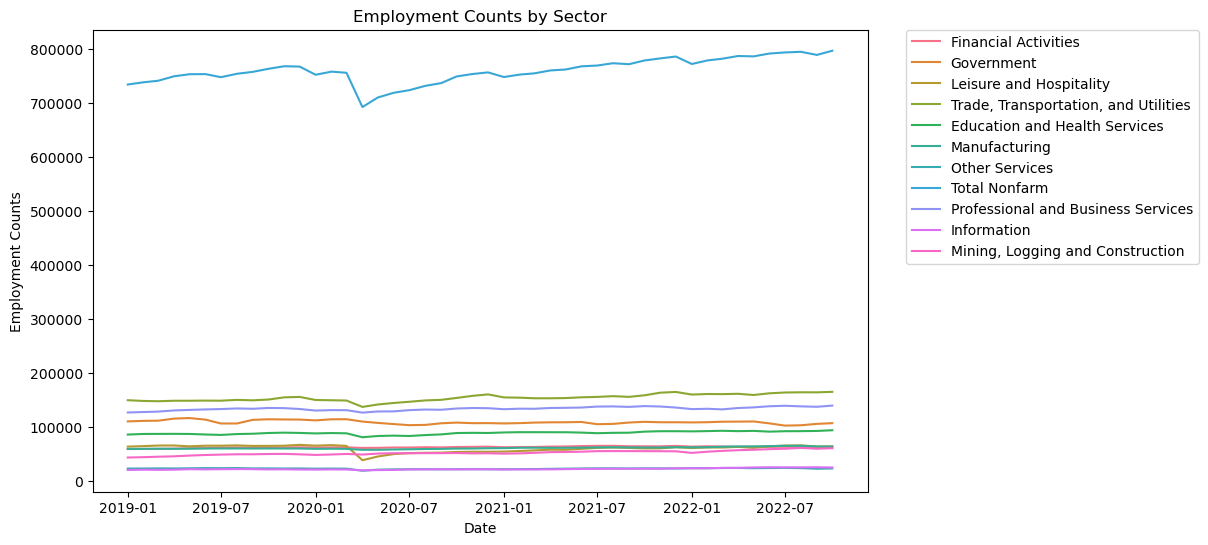

In [12]:
# Plotting employment counts by sector
plt.figure(figsize=(10,6))
sns.lineplot(data=employment_df, x='Date', y='Employment', hue='Sector')
plt.title('Employment Counts by Sector')
plt.xlabel('Date')
plt.ylabel('Employment Counts')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

It looks like there is a dip earlier in 2020 however, it is hard to discern the drop for each individual sector. Let us try to get the percentage changes.

In [13]:
# Get percentage change in employment counts by sector
employment_df['Employment_pct_change'] = employment_df.groupby('Sector')['Employment'].pct_change()

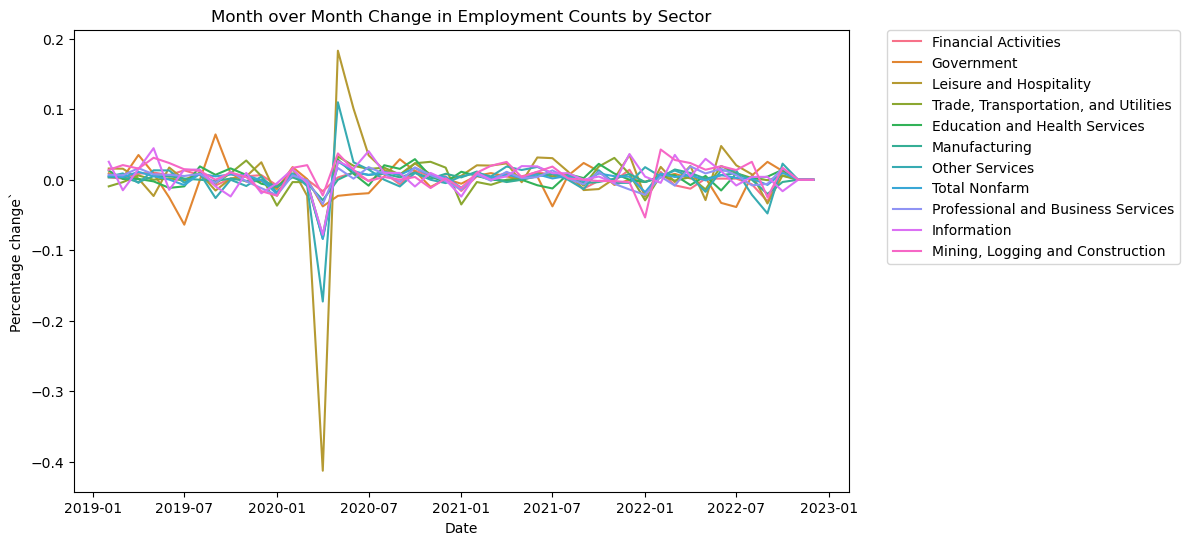

In [14]:
# Plotting employment counts by sector
plt.figure(figsize=(10,6))
sns.lineplot(data=employment_df, x='Date', y='Employment_pct_change', hue='Sector')
plt.title('Month over Month Change in Employment Counts by Sector')
plt.xlabel('Date')
plt.ylabel('Percentage change`')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Much better. We can see that leisure and hospitality had a huge dip and then a huge gain. We can make this plot clearer.

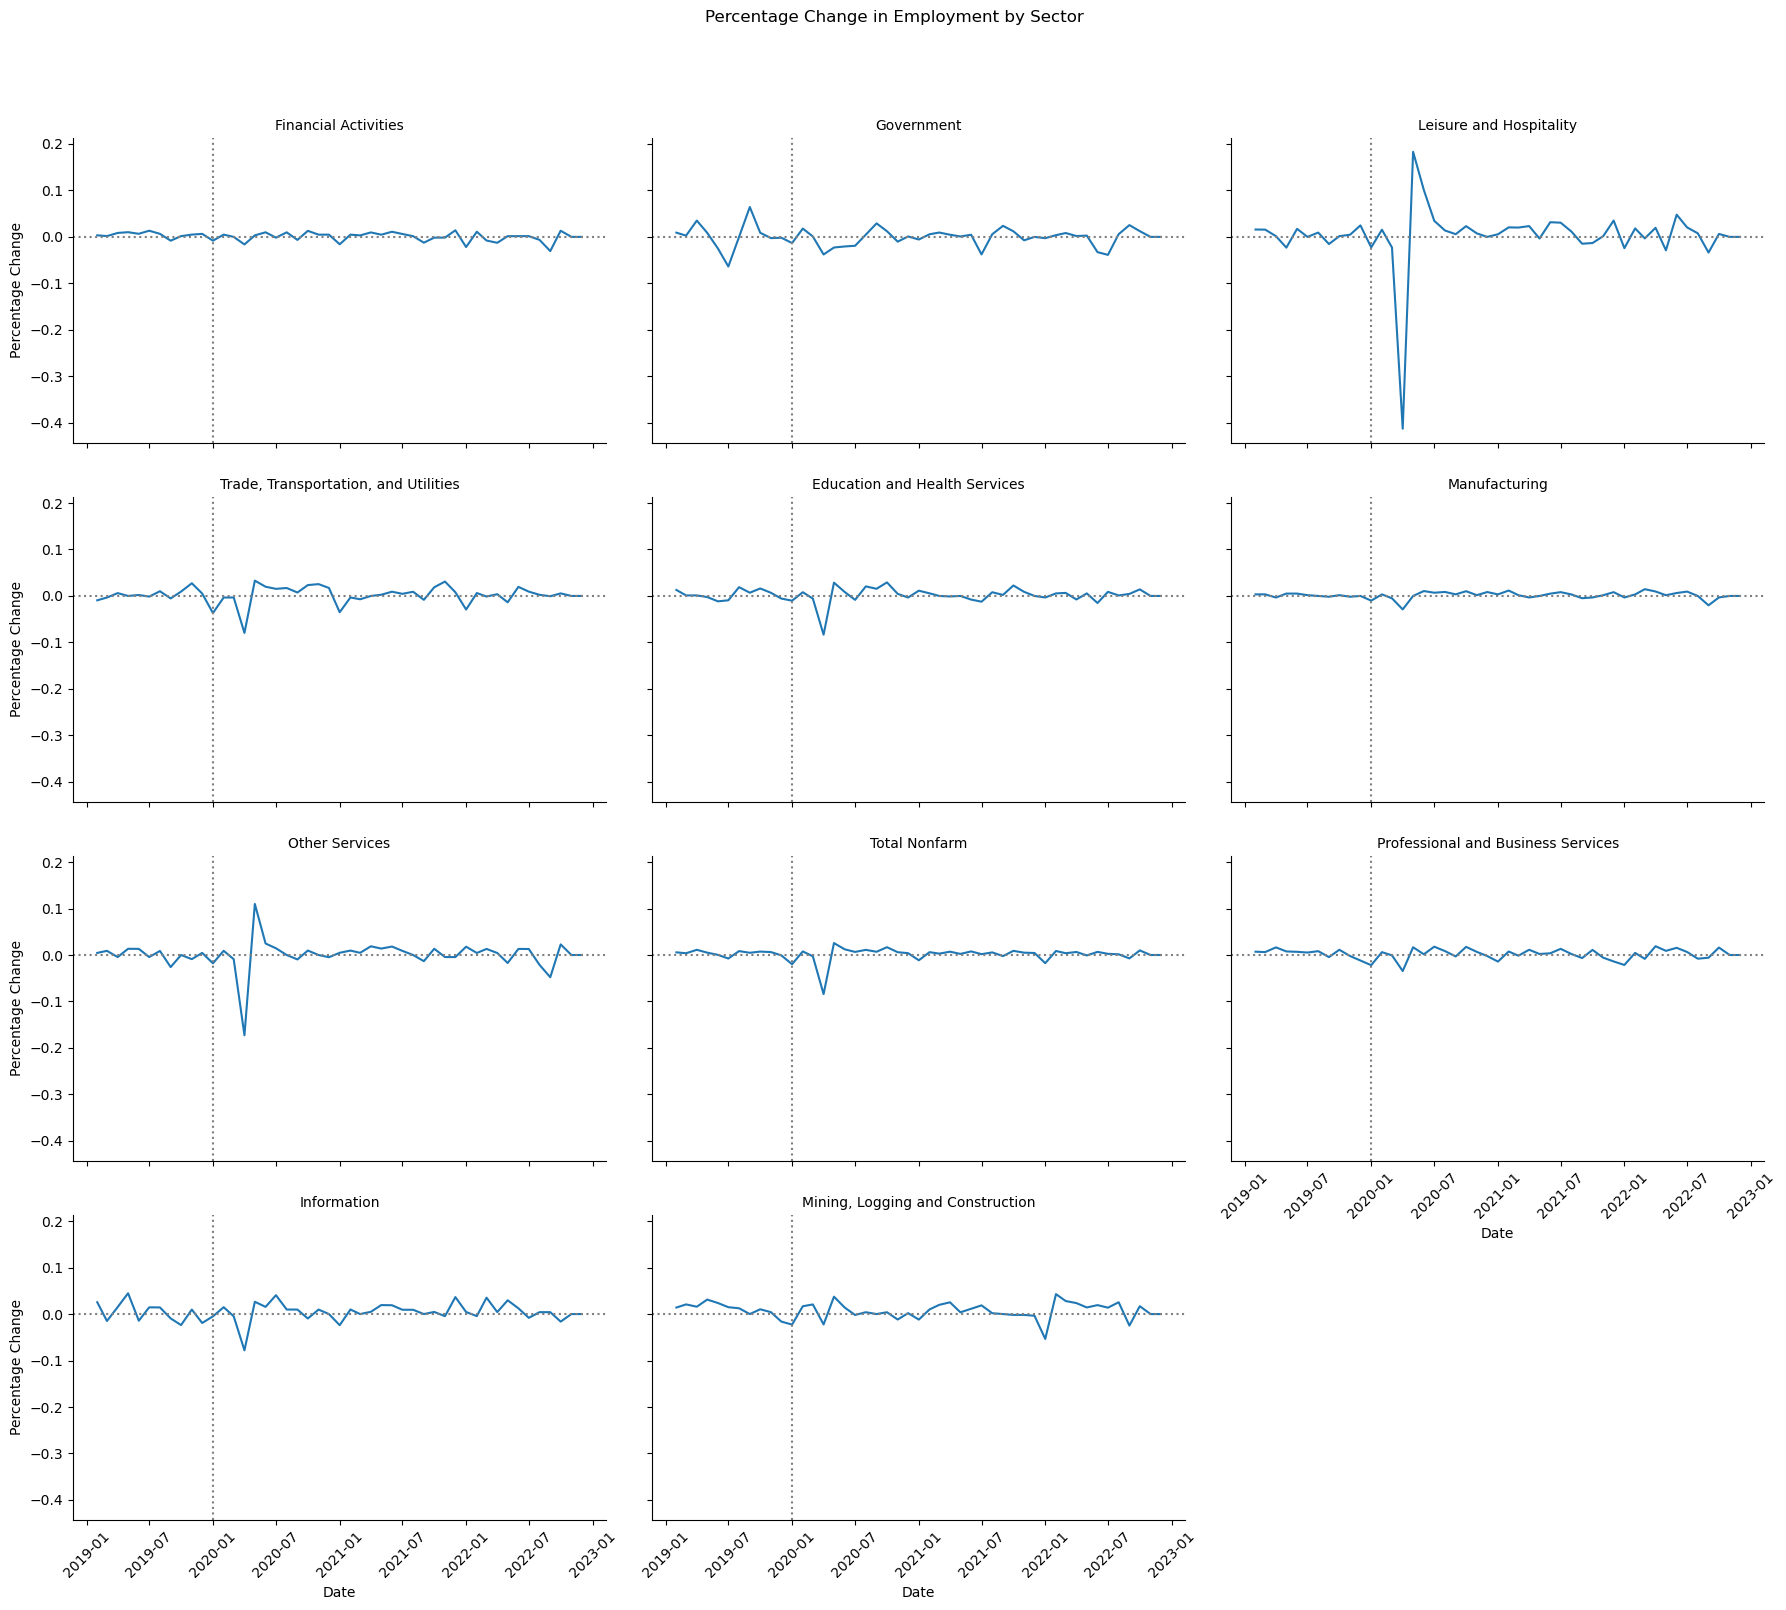

In [15]:
# Make a facet grid of employment counts by sector except for total nonfarm
g = sns.FacetGrid(employment_df, col="Sector", col_wrap=3, height=4, aspect=1.5)
g.map(sns.lineplot, "Date", "Employment_pct_change")
# Add a title to the figure
g.fig.suptitle('Percentage Change in Employment by Sector')
g.set_titles("{col_name}")
# Add a horizontal line at y=0
g.map(plt.axhline, y=0, ls=":", c=".5")
# Add a vertical line at x=Jan 2020
g.map(plt.axvline, x=pd.to_datetime('2020-01-01'), ls=":", c=".5")
g.set_axis_labels("Date", "Percentage Change")
g.set_xticklabels(rotation=45)
plt.subplots_adjust(top=0.9)

A few observations here:

1. Most sectors seem to have bounced back fairly quick even after suffering huge declines in employment
2. Fianacial activities, mining, logging and construction, manufacturing reamined realtively less affected by the pandemic
3. Leisure and hospitality, education and health services, information, trade, transportation and utilities and other services suffered setbacks during the pandemic. All these sectors suffered setabcks but bounced back with growth in employment. It remains to be seen if the counts hit pre-pandemic levels

We could plot the raw employment counts and the percentage changes on a dual axis.

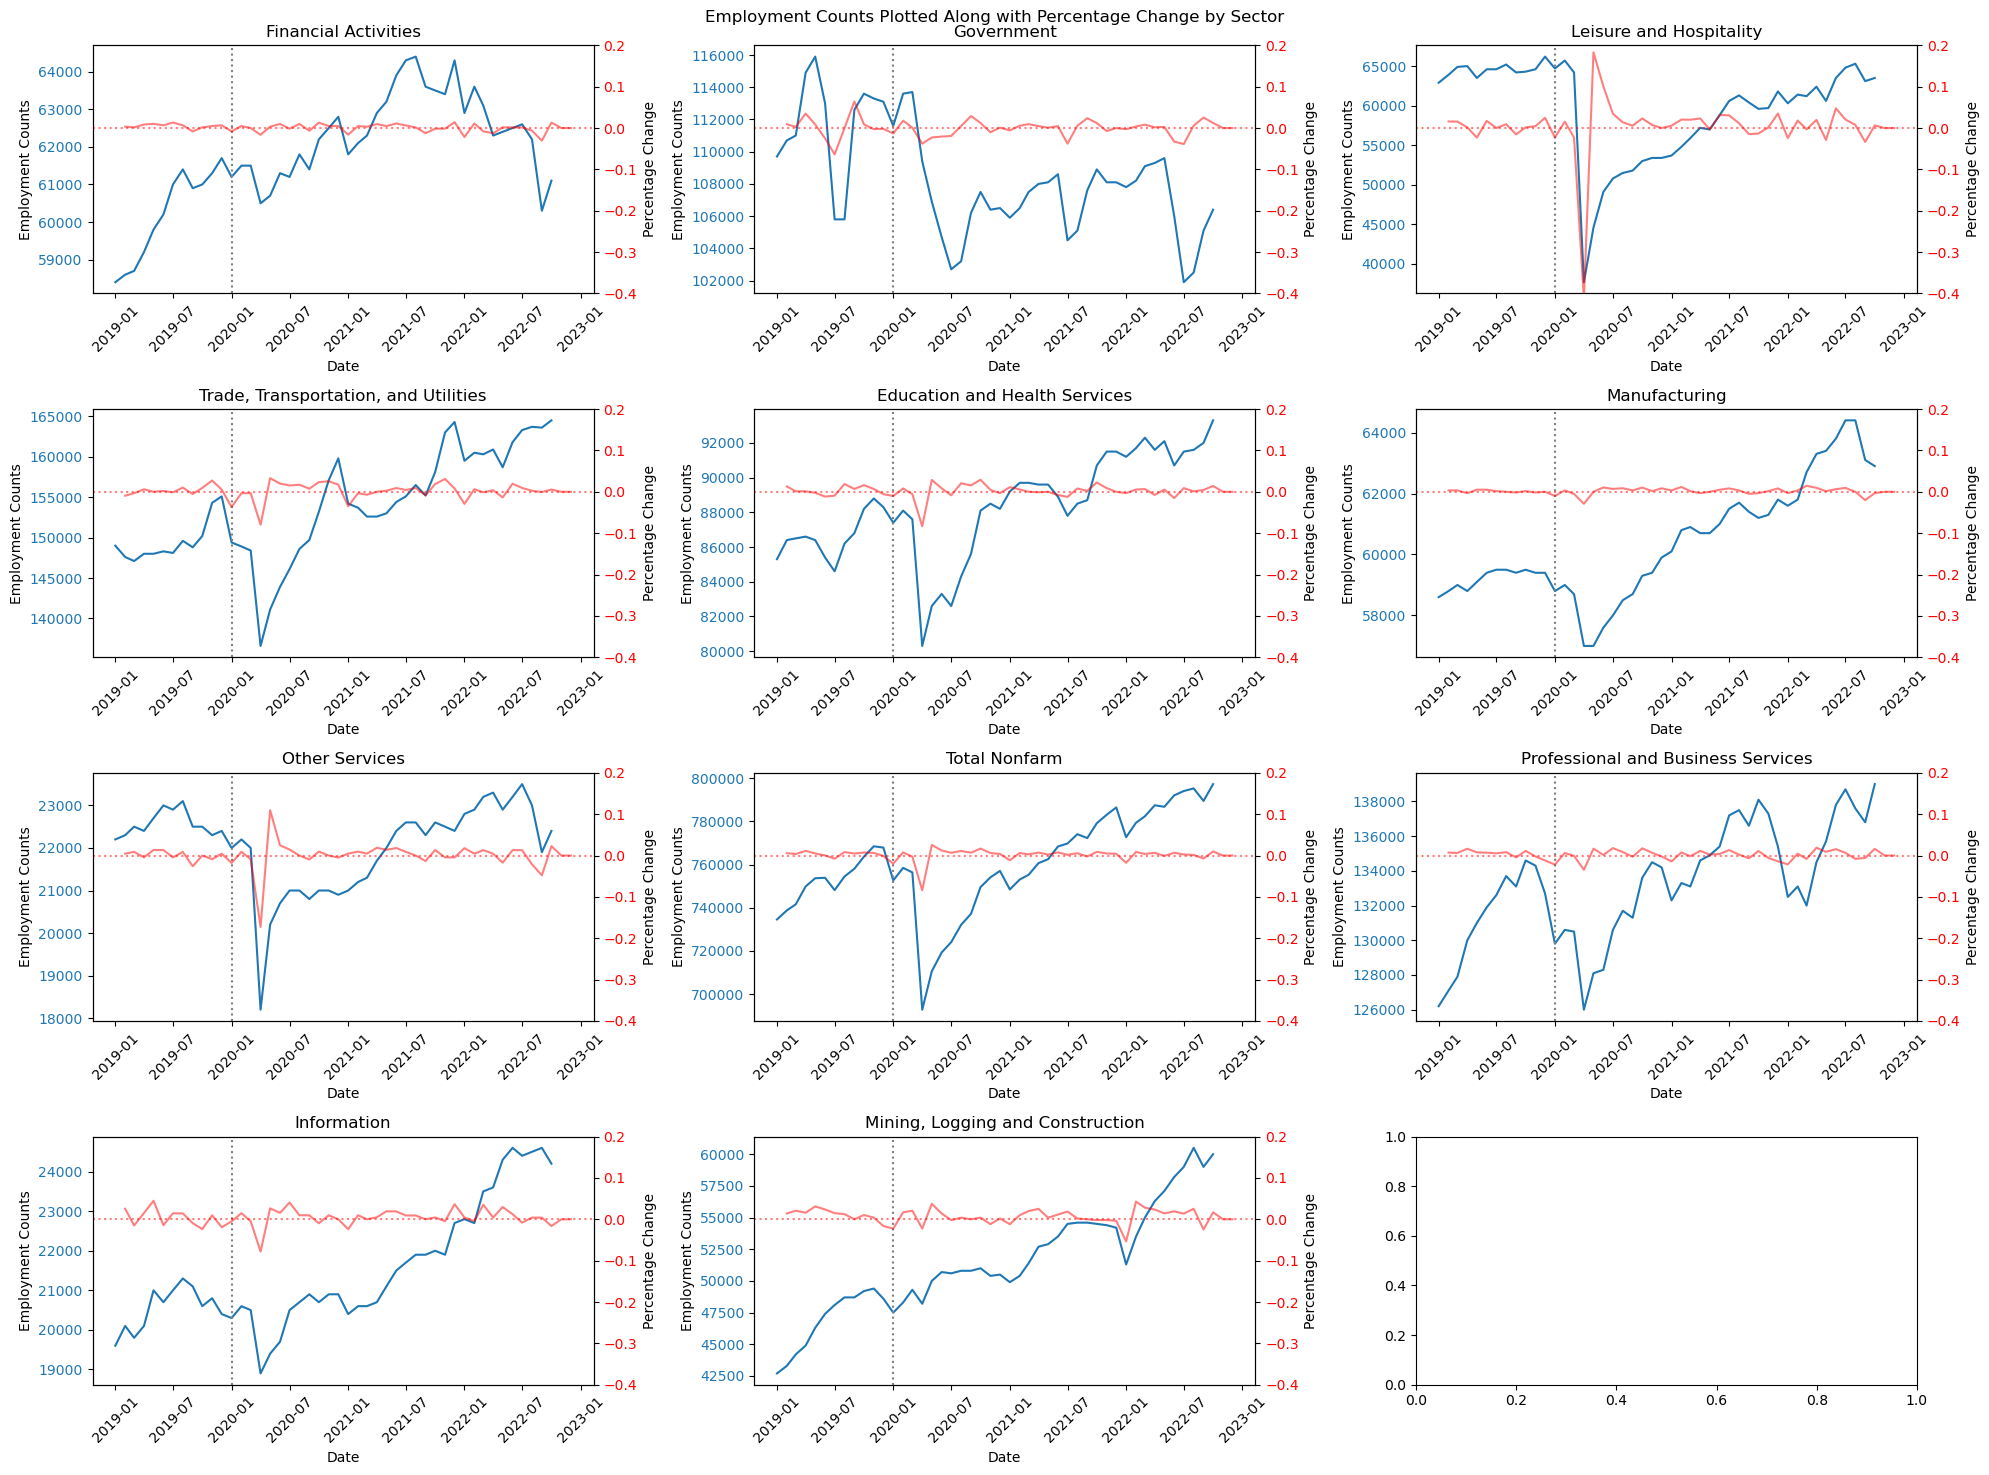

In [23]:
# Create 12 subplots, one for each sector
fig, axes = plt.subplots(4, 3, figsize=(20, 15))
fig.suptitle('Employment Counts Plotted Along with Percentage Change by Sector')
for i, sector in enumerate(employment_df['Sector'].unique()):
    ax = axes[i//3, i%3]
    sns.lineplot(data=employment_df[employment_df['Sector']==sector], x='Date', y='Employment', ax=ax)
    ax.set_title(sector)
    ax.set_xlabel('Date')
    ax.set_ylabel('Employment Counts')
    ax.axvline(x=pd.to_datetime('2020-01-01'), ls=":", c=".5")
    ax.tick_params(axis='x', rotation=45)
    # Add more space between the subplots
    fig.tight_layout()
    # Add a dual y-axis for percentage change
    ax2 = ax.twinx()
    sns.lineplot(data=employment_df[employment_df['Sector']==sector], x='Date', y='Employment_pct_change', ax=ax2, color='red', alpha=0.5)
    ax2.set_ylabel('Percentage Change')
    ax2.axhline(y=0, ls=":", c="red", alpha=0.5)
    ax2.set_ylim(-0.4, 0.2)
    # Color yaxis labels red
    for t in ax2.get_yticklabels():
        t.set_color('red')
    for t in ax.get_yticklabels():
        t.set_color('tab:blue')

1. It is clear from the plot above that all sectors that suffered employment losses have recovered eventually with the exception of the government sector
   1. The government sector appears to follow a seasonal pattern and the number of jobs seems to have stagnated below pre-pandemic levels
   2. The financial activities sector suffered losses only in the year 2022, likely due to reasons unrelated to the pandemic
2. next, we compare this visualization with vaccine adherence

## 3.2 Research Question 2

How have income and employment growth patterns changed post-pandemic?

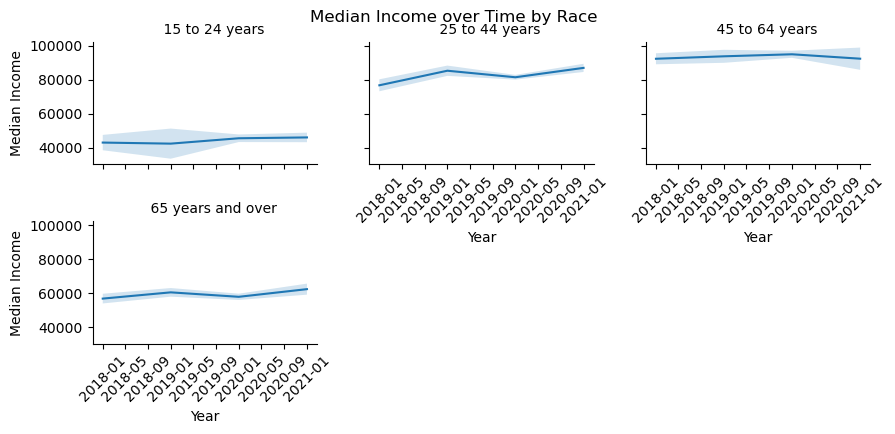

In [17]:
g = sns.FacetGrid(age_income_df, col="Label (Grouping)", col_wrap=3, height=2, aspect=1.5)
g.map(sns.lineplot, "Year", "Median Income")
# Add a title to the figure
g.fig.suptitle('Median Income over Time by Race')
g.set_titles("{col_name}")
g.set_xticklabels(rotation=45)
plt.subplots_adjust(top=0.9)
for ax,race in zip(g.axes,age_income_df['Label (Grouping)'].unique()):
    ax.fill_between(x=age_income_df.Year.unique(), \
        y1=age_income_df.loc[age_income_df["Label (Grouping)"]==race,"Lower Bound"],\
        y2=age_income_df.loc[age_income_df["Label (Grouping)"]==race,"Upper Bound"], alpha=0.2)

There is a caveat with the data. For the year 2020, we use the 5-year ACS survey data since that is the only estimate available. For the remaining years, we use the 1-year estimates.

We see that income fell in 2020, for most groups, which then recovered in 2021. Interestingly, income for African-Americans has been consistently on the rise. American-Indians also see an increase in 2020 income, which then falls in 2021.

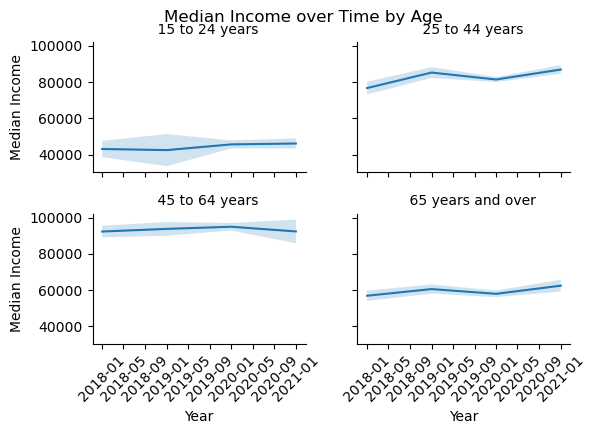

In [18]:
g = sns.FacetGrid(age_income_df, col="Label (Grouping)", col_wrap=2, height=2, aspect=1.5)
g.map(sns.lineplot, "Year", "Median Income")
# Add a title to the figure
g.fig.suptitle('Median Income over Time by Age')
g.set_titles("{col_name}")
g.set_xticklabels(rotation=45)
plt.subplots_adjust(top=0.9)
for ax,race in zip(g.axes,age_income_df['Label (Grouping)'].unique()):
    ax.fill_between(x=age_income_df.Year.unique(), \
        y1=age_income_df.loc[age_income_df["Label (Grouping)"]==race,"Lower Bound"],\
        y2=age_income_df.loc[age_income_df["Label (Grouping)"]==race,"Upper Bound"], alpha=0.2)

## 3.3 Research Question 3

Do vaccination rates have a part to play in affecting employment patterns?

We extract vaccination rates over time. Specifically, we note the start of the pandemic, the point at which 50% of the population was fully vaccinated, and the point of maximum vaccination in the county.

In [19]:
vax_25_date = covid_vaccination[covid_vaccination["Series_Complete_18PlusPop_Pct"]>=25]["Date"].min()
vax_50_date = covid_vaccination[covid_vaccination["Series_Complete_18PlusPop_Pct"]>=50]["Date"].min()
vax_70_date = covid_vaccination[covid_vaccination["Series_Complete_18PlusPop_Pct"]>=80]["Date"].min()
print(f"25% of the population was fully vaccinated on {vax_25_date}")
print(f"50% of the population was fully vaccinated on {vax_50_date}")
print(f"70% of the population was fully vaccinated on {vax_70_date}")

25% of the population was fully vaccinated on 2021-04-13 00:00:00
50% of the population was fully vaccinated on 2021-06-13 00:00:00
70% of the population was fully vaccinated on 2022-02-09 00:00:00


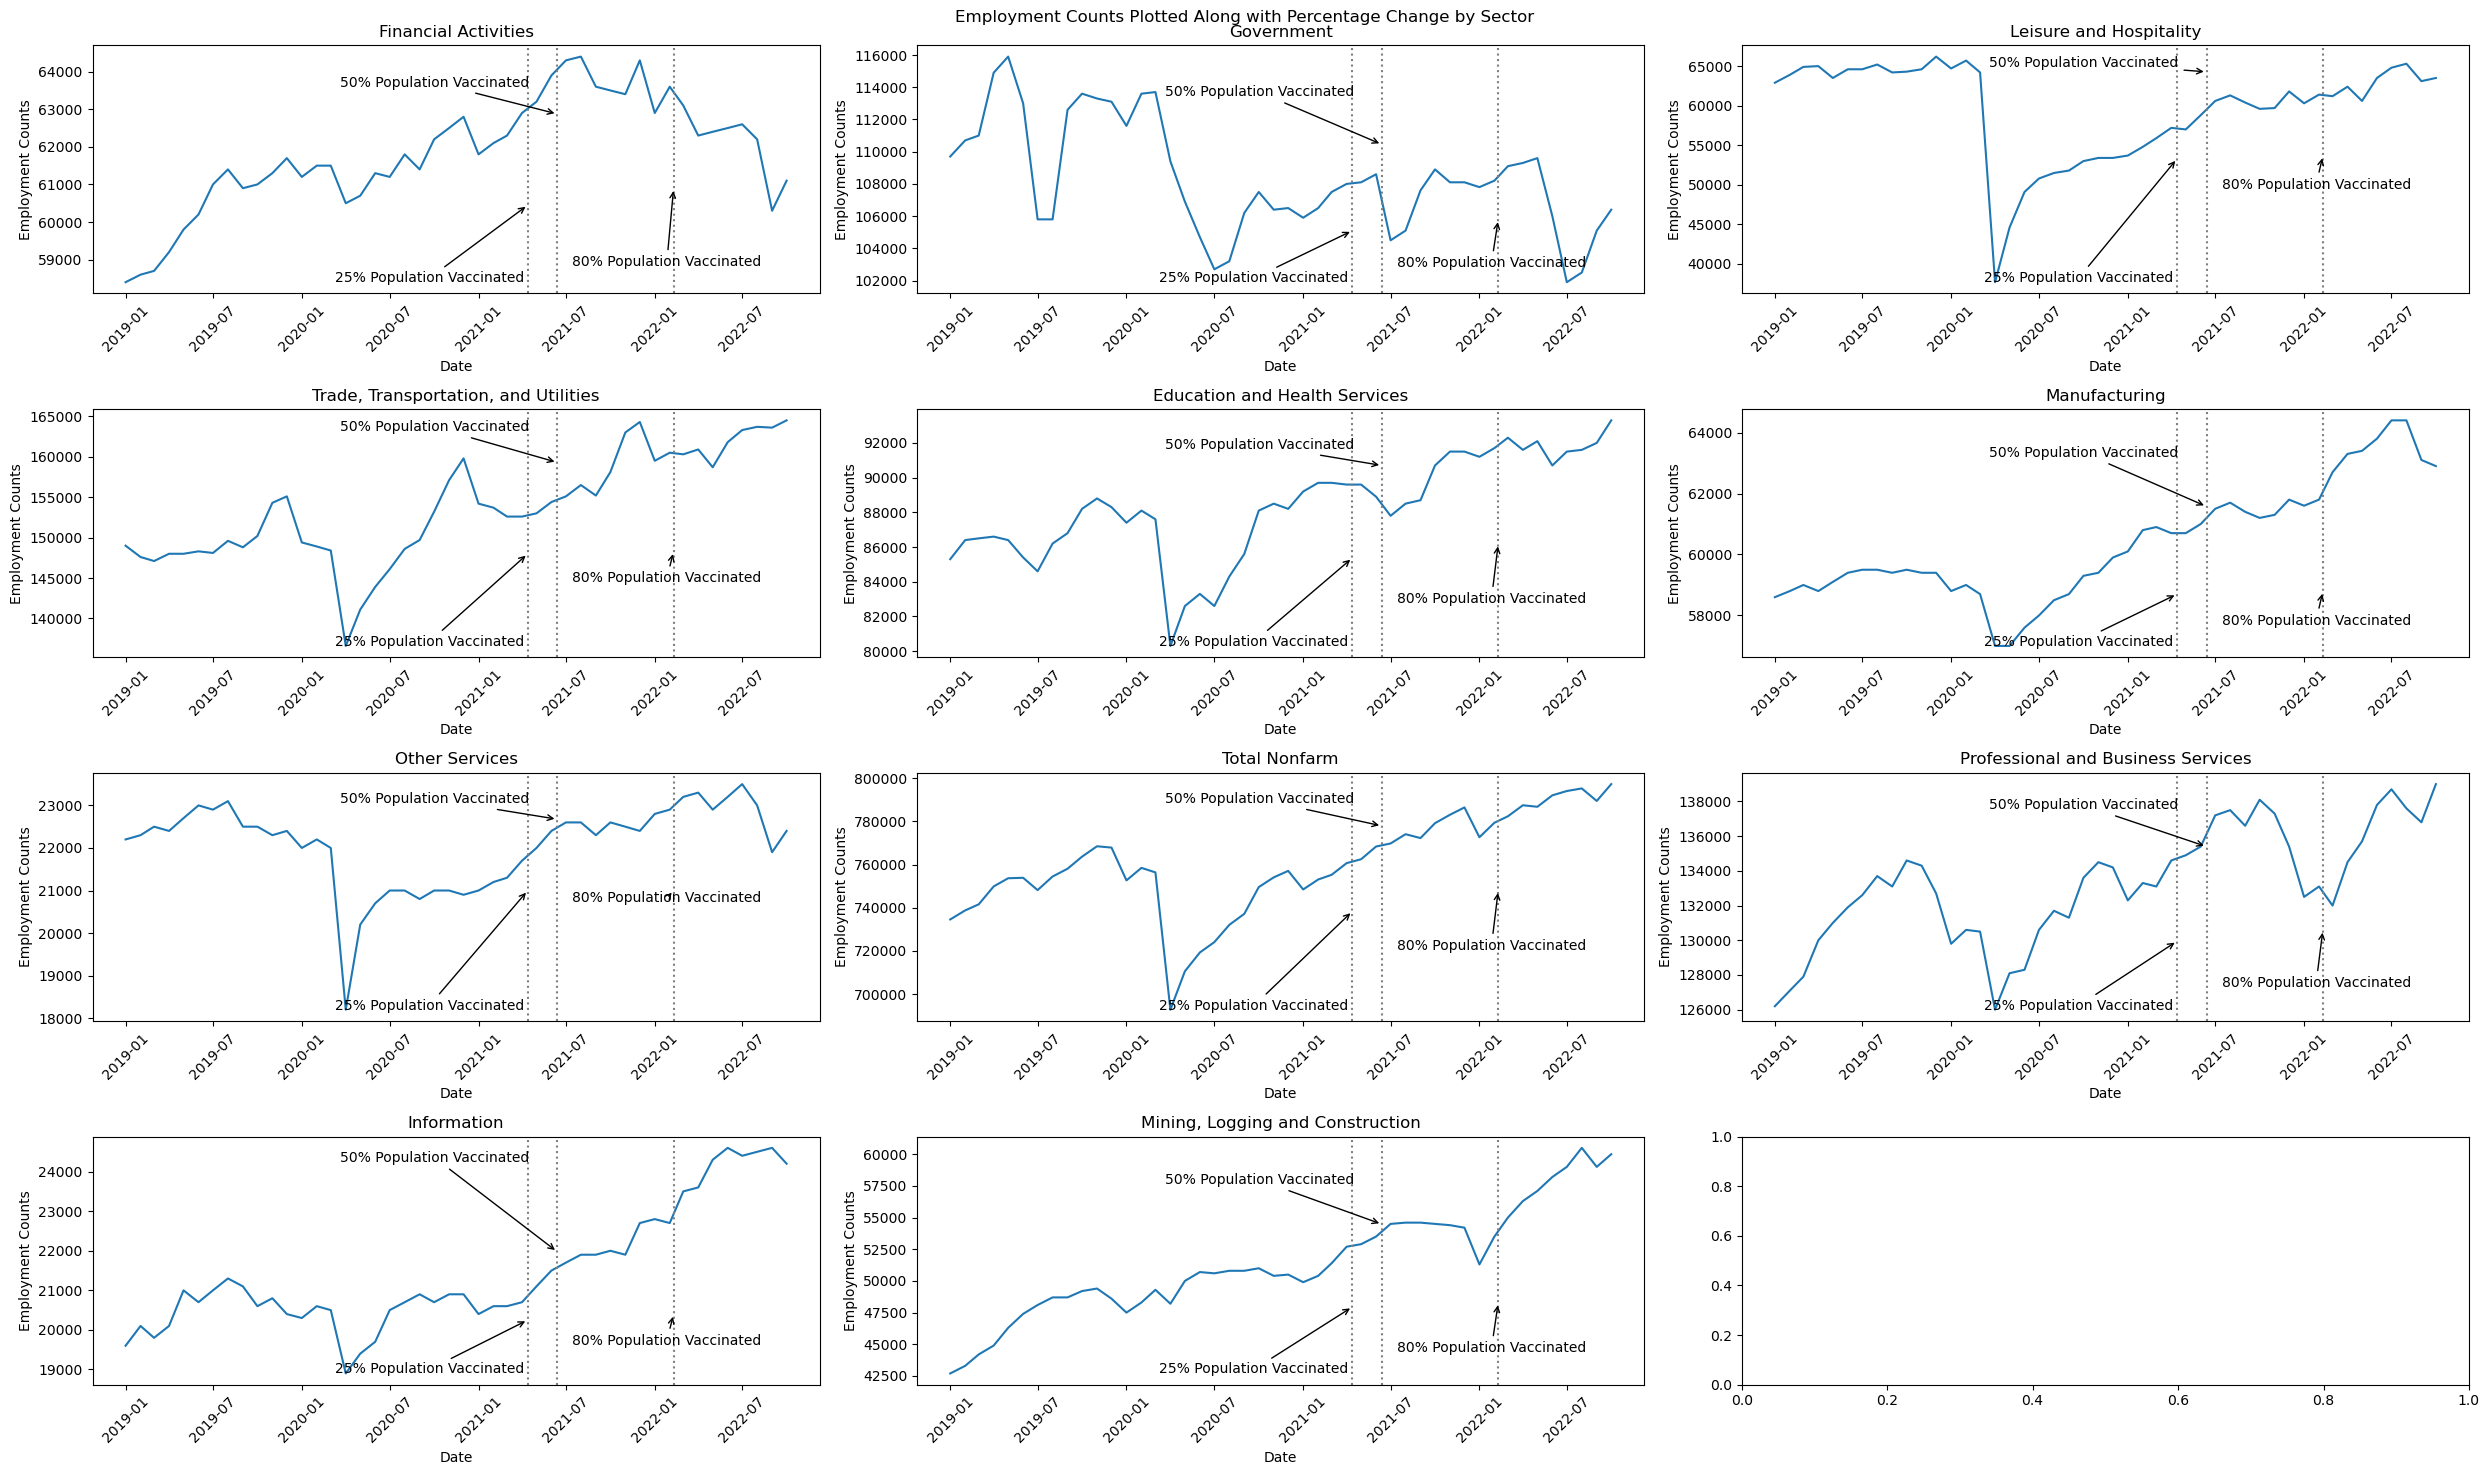

In [28]:
# Create 12 subplots, one for each sector
fig, axes = plt.subplots(4, 3, figsize=(25, 15))
fig.suptitle('Employment Counts Plotted Along with Percentage Change by Sector')
for i, sector in enumerate(employment_df['Sector'].unique()):
    ax = axes[i//3, i%3]
    data = employment_df[employment_df['Sector']==sector]
    sns.lineplot(data=data, x='Date', y='Employment', ax=ax)
    ax.set_title(sector)
    ax.set_xlabel('Date')
    ax.set_ylabel('Employment Counts')
    # ax.axvline(x=pd.to_datetime('2020-01-01'), ls=":", c=".5")
    # # Annotate the line with start of pandemic
    # ax.annotate('Start of Pandemic', xy=(pd.to_datetime('2020-01-01'), data["Employment"].quantile(0.15)),\
    #      xytext=(pd.to_datetime('2019-01-01'), data["Employment"].min()), rotation=0,
    #      arrowprops=dict(arrowstyle="->"))
    ax.axvline(x=vax_25_date, ls=":", c=".5")
    # Annotate the line with 25% of the population vaccinated
    ax.annotate('25% Population Vaccinated', xy=(vax_25_date, data["Employment"].quantile(0.15)),\
            xytext=(vax_25_date-timedelta(days=400), data["Employment"].min()), rotation=0,
            arrowprops=dict(arrowstyle="->"))
    ax.axvline(x=vax_50_date, ls=":", c=".5")
    # Annotate the line with 50% of the population vaccinated
    ax.annotate('50% Population Vaccinated', xy=(vax_50_date, data["Employment"].quantile(0.75)),\
        xytext=(vax_50_date-timedelta(days=450), data["Employment"].quantile(0.9)), rotation=0,
        arrowprops=dict(arrowstyle="->"))
    ax.axvline(x=vax_70_date, ls=":", c=".5")
    # Annotate the line with 70% of the population vaccinated
    ax.annotate('80% Population Vaccinated', xy=(vax_70_date, data["Employment"].quantile(0.2)),\
        xytext=(vax_70_date-timedelta(days=210), data["Employment"].quantile(0.05)), rotation=0,
        arrowprops=dict(arrowstyle="->"))
    ax.tick_params(axis='x', rotation=45)
    # Add more space between the subplots
    fig.tight_layout()

We can see that most industries recovered in employment numbers well before vaccinations began. Some industries do see an uptick in employment as vaccination rates increase, even more than pre-pandemic levels in some cases

In [27]:
vax_begin_date = covid_vaccination[covid_vaccination["Series_Complete_18PlusPop_Pct"]>0]["Date"].min()


Timestamp('2021-04-13 00:00:00')